In [1]:
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
from sklearn.utils import shuffle
import random
import tensorflow as tf

from PIL import Image, ImageDraw
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import os
import time
import tensorflow as tf
import datetime

In [2]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image 
  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]
  

  
  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

In [3]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return input_image, real_image

def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
  return cropped_image[0], cropped_image[1]

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1
  return input_image, real_image


def random_jitter(input_image, real_image):
  # Resizing to 286x286
  
  input_image, real_image = resize(input_image, real_image, 572, 572) 
  
  input_image, real_image = random_crop(input_image, real_image)
    
  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

In [4]:
def load_image_train(image_file):
    
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [5]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

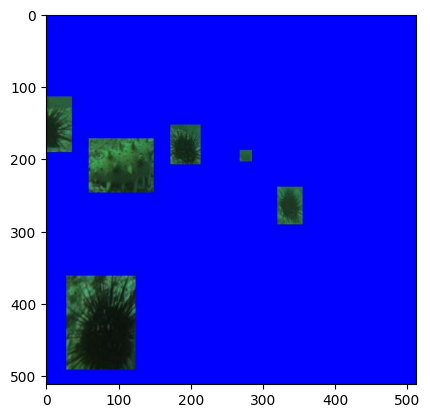

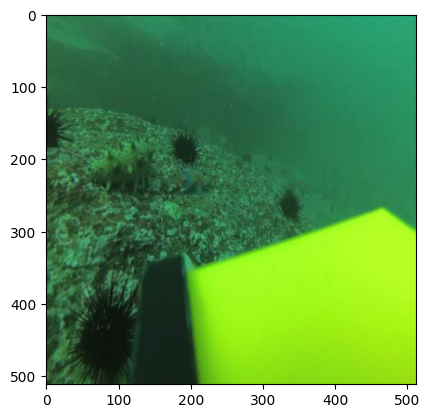

In [6]:
inp, re = load('Dataset/test/merged_with_cutouts/0053_jpg.rf.09c5a0f5af288f9426616259b0307fae.jpg')
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

In [7]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 512
IMG_HEIGHT = 512

In [8]:
train_dataset = tf.data.Dataset.list_files('Dataset/train/merged_with_cutouts/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

#try:
test_dataset = tf.data.Dataset.list_files('Dataset/test/merged_with_cutouts/*.jpg')
#except tf.errors.InvalidArgumentError:
  #test_dataset = tf.data.Dataset.list_files('Dataset/valid/mixed_animals/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [9]:
OUTPUT_CHANNELS = 3
def downsample(filters, size, apply_batchnorm=True, strides=2):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=strides, padding='same',
                               kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

def Generator():
  inputs = tf.keras.layers.Input(shape=[512, 512, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(1024, 4),  # (batch_size, 1, 1, 512)
    downsample(1024, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(1024, 4, apply_dropout=True), 
    upsample(1024, 4, apply_dropout=True),   
    upsample(512, 4, apply_dropout=True), 
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

generator = Generator()
generator.summary()




(1, 256, 256, 3)
(1, 512, 512, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_2 (Sequential)      (None, 256, 256, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_3 (Sequential)      (None, 128, 128, 12  131584      ['sequential_2[0][0]']           
                                8)                          

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


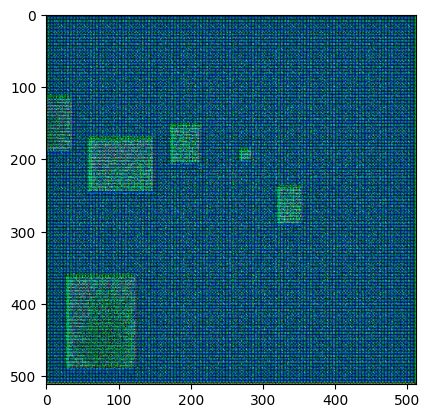

In [10]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [10]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [11]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[512, 512, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[512, 512, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)
  down4 = downsample(512, 4)(down3)
  down5 = downsample(1024, 4)(down3)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down5)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)


In [12]:
discriminator= Discriminator()
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 target_image (InputLayer)      [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_8 (Concatenate)    (None, 512, 512, 6)  0           ['input_image[0][0]',            
                                                                  'target_image[0][0]']     

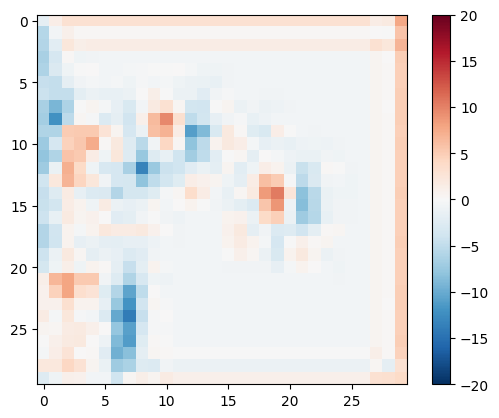

In [14]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()


In [13]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [14]:
class Pix2Pix(tf.keras.Model):
    def __init__(self, generator, discriminator):
        super(Pix2Pix, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_optimizer, d_optimizer, gen_loss_fn, disc_loss_fn):
        super(Pix2Pix, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        

    def train_step(self, data):
        input_image, target = data

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            gen_output = self.generator(input_image, training=True)
            disc_real_output = self.discriminator([input_image, target], training=True)
            disc_generated_output = self.discriminator([input_image, gen_output], training=True)

            gen_total_loss, gen_gan_loss, gen_l1_loss = self.gen_loss_fn(disc_generated_output, gen_output, target)
            disc_loss = self.disc_loss_fn(disc_real_output, disc_generated_output)

        generator_gradients = gen_tape.gradient(gen_total_loss, self.generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.g_optimizer.apply_gradients(zip(generator_gradients, self.generator.trainable_variables))
        self.d_optimizer.apply_gradients(zip(discriminator_gradients, self.discriminator.trainable_variables))

        return {'gen_total_loss': gen_total_loss, 'disc_loss': disc_loss}
    
    def call(self, inputs, training=False):
        # Aquí definimos el flujo de datos a través del modelo durante la inferencia
        if training:
            # Durante el entrenamiento, solo necesitamos el generador
            generated_image = self.generator(inputs, training=False)
            return self.discriminator([inputs, generated_image], training=False)
            
        else:
            # Durante la inferencia, generamos la salida y la pasamos a través del discriminador       
            return self.generator(inputs, training=True)


In [15]:
def plot_sample_images(dataset, model, num_samples=1):
    for input_image, target in dataset.take(num_samples):
        prediction = model(input_image,training=False)
        plt.figure(figsize=(15, 5))

        display_list = [input_image[0], target[0], prediction[0]]
        title = ['Input Image', 'Ground Truth', 'Predicted Image']

        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(title[i])
            # Ajusta esta línea si tu rango de datos es diferente
            plt.imshow((display_list[i] * 0.5 + 0.5).numpy())
            plt.axis('off')
        plt.show()

In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, LambdaCallback
def on_epoch_end_callback(epoch, logs):
    # Guardar las métricas
    metrics_filename = os.path.join(model_directory, f'metrics_epoch_{epoch+1}.txt')
    with open(metrics_filename, 'w') as f:
        for metric, value in logs.items():
            f.write(f'{metric}: {value}\n')

    # Guardar los pesos del modelo
    model_weights_filename = os.path.join(model_directory, f'model_weights_epoch_{epoch+1}.h5')
    model.save_weights(model_weights_filename)

    # Generar y guardar algunas imágenes de muestra
    plot_sample_images(test_dataset, model)

epoch_end_callback = LambdaCallback(on_epoch_end=on_epoch_end_callback)

reduce_lr_g = ReduceLROnPlateau(monitor='gen_total_loss', factor=0.1, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
reduce_lr_d = ReduceLROnPlateau(monitor='disc_loss', factor=0.1, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)


In [25]:
import os

NUM_EPOCHS = 50
metric_history = []

model_directory = 'path_to_save_model'

# Crear el directorio si no existe
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
    
model = Pix2Pix(generator, discriminator)
model.compile(
    g_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    d_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss,
    disc_loss_fn=discriminator_loss)

epoch_end_callback = LambdaCallback(on_epoch_end=on_epoch_end_callback)

# Entrenar el modelo
history = model.fit(
    train_dataset, 
    epochs=NUM_EPOCHS,
    callbacks=[ epoch_end_callback]
)

# Después de finalizar el entrenamiento, puedes procesar 'history' para ver la evolución de las métricas
metric_history = history.history

Epoch 1/50


ResourceExhaustedError: Graph execution error:

Detected at node 'model/sequential_18/batch_normalization_17/FusedBatchNormV3' defined at (most recent call last):
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\asyncio\base_events.py", line 541, in run_forever
      self._run_once()
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\asyncio\base_events.py", line 1786, in _run_once
      handle._run()
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\asyncio\events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2915, in run_cell
      raw_cell, store_history, silent, shell_futures)
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3186, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\ramalmar\AppData\Local\Temp\ipykernel_18104\3105717081.py", line 25, in <module>
      callbacks=[ epoch_end_callback]
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\ramalmar\AppData\Local\Temp\ipykernel_18104\2000480720.py", line 19, in train_step
      gen_output = self.generator(input_image, training=True)
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 661, in _fused_batch_norm
      training, _fused_batch_norm_training, _fused_batch_norm_inference
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\control_flow_util.py", line 109, in smart_cond
      pred, true_fn=true_fn, false_fn=false_fn, name=name
    File "C:\Users\ramalmar\anaconda3\envs\tensorflow\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 645, in _fused_batch_norm_training
      exponential_avg_factor=exponential_avg_factor,
Node: 'model/sequential_18/batch_normalization_17/FusedBatchNormV3'
OOM when allocating tensor with shape[1,256,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/sequential_18/batch_normalization_17/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_427140]

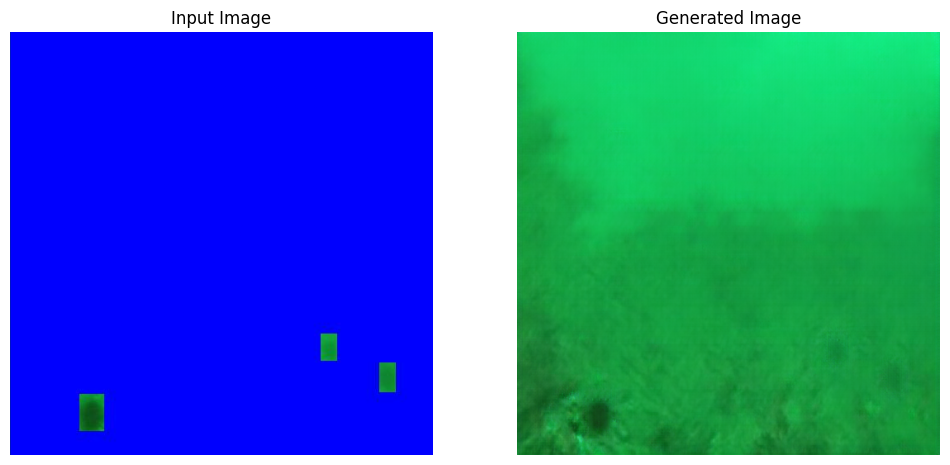

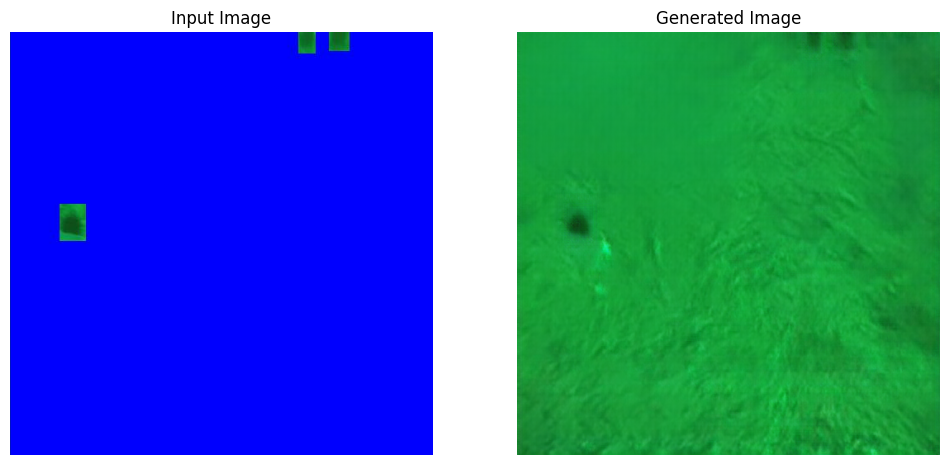

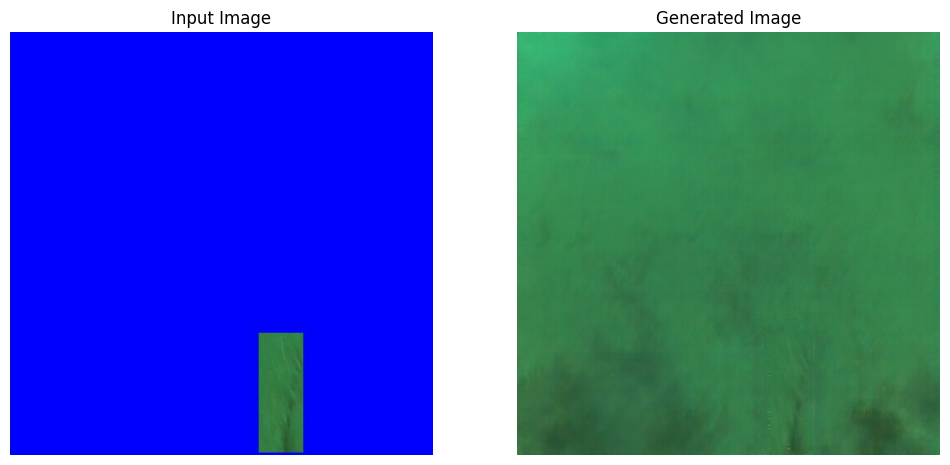

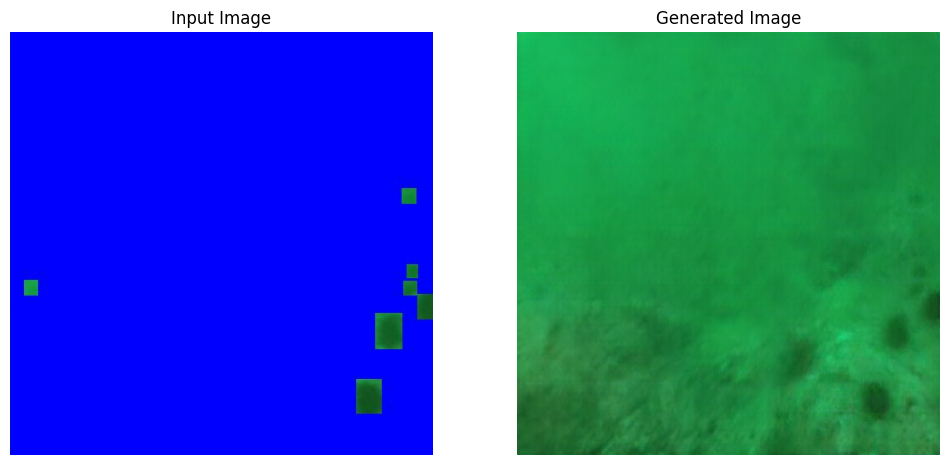

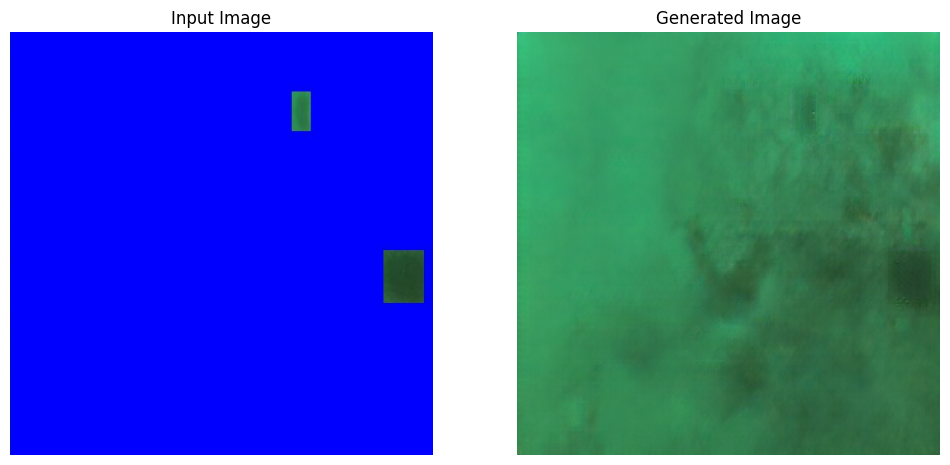

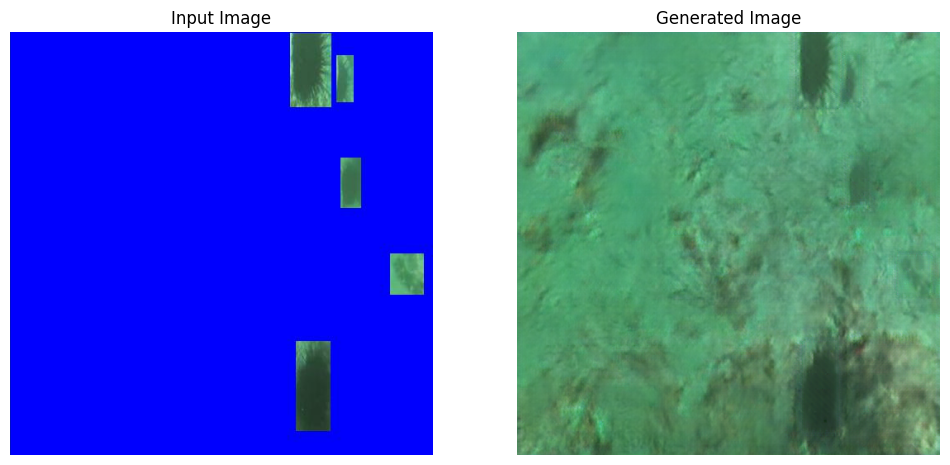

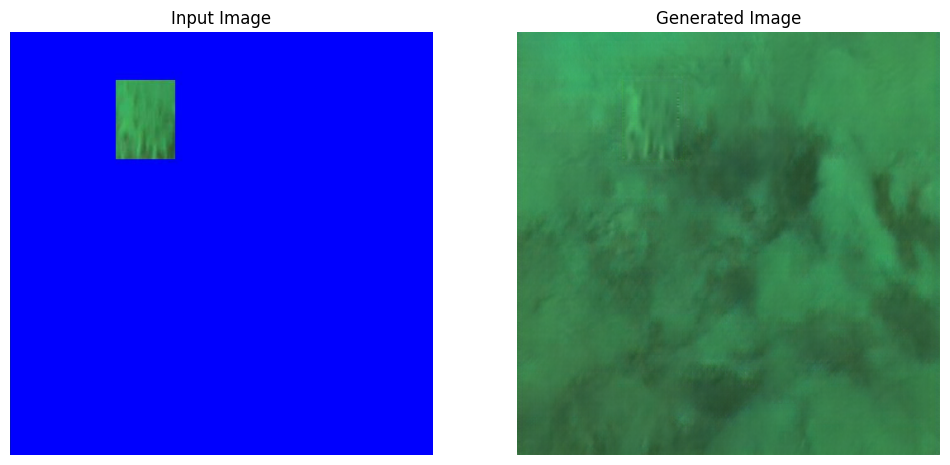

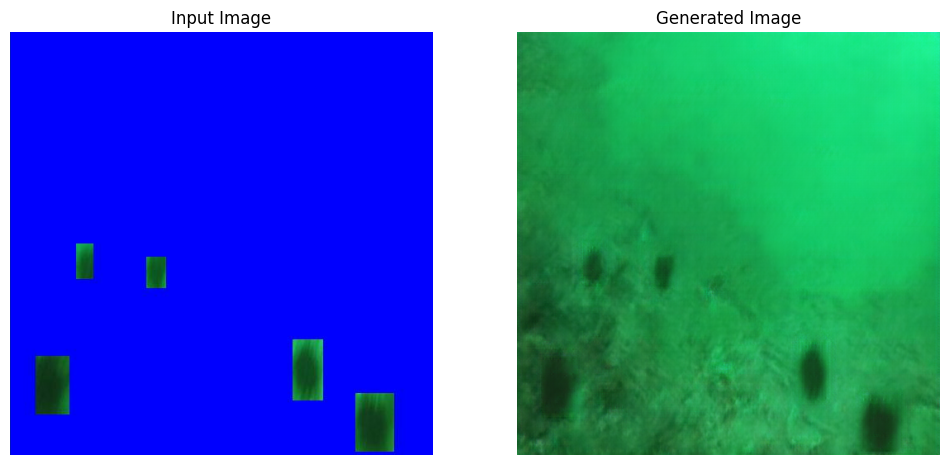

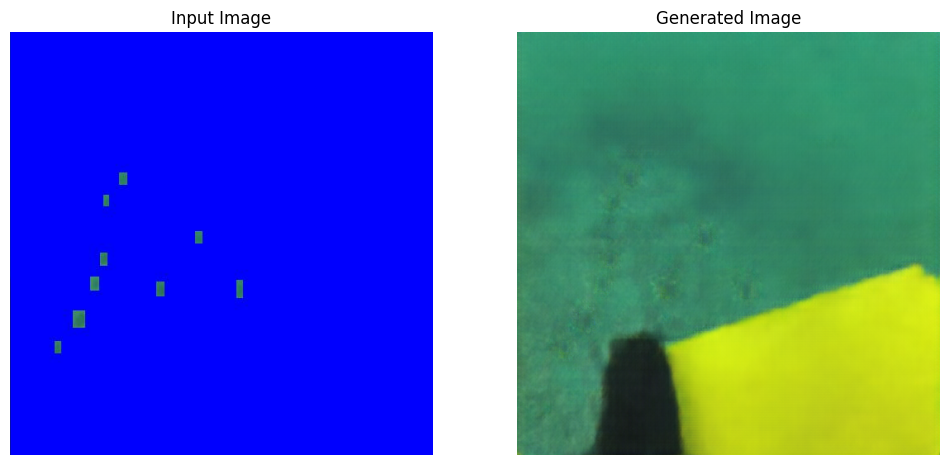

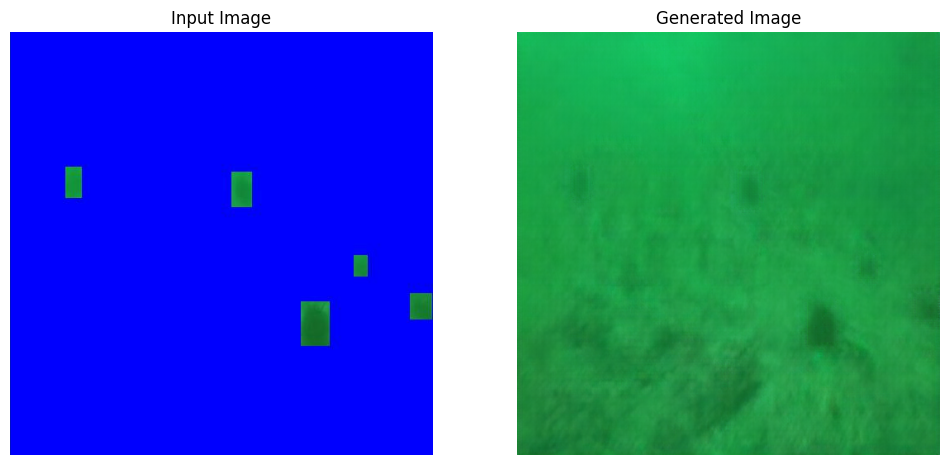

In [20]:
# Asumiendo que `model` es tu modelo Pix2Pix entrenado y `test_dataset` es tu conjunto de datos
# Seleccionar 10 muestras aleatorias del conjunto de datos
for i, (input_image, _) in enumerate(test_dataset.take(10)):
    # Generar la imagen
    generated_image = model(input_image, training=False)

    # Visualizar la imagen de entrada y la imagen generada
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title('Input Image')
    plt.imshow(input_image[0] * 0.5 + 0.5)  # Reajustar la normalización si es necesario
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Generated Image')
    plt.imshow(generated_image[0] * 0.5 + 0.5)  # Reajustar la normalización si es necesario
    plt.axis('off')

    plt.show()

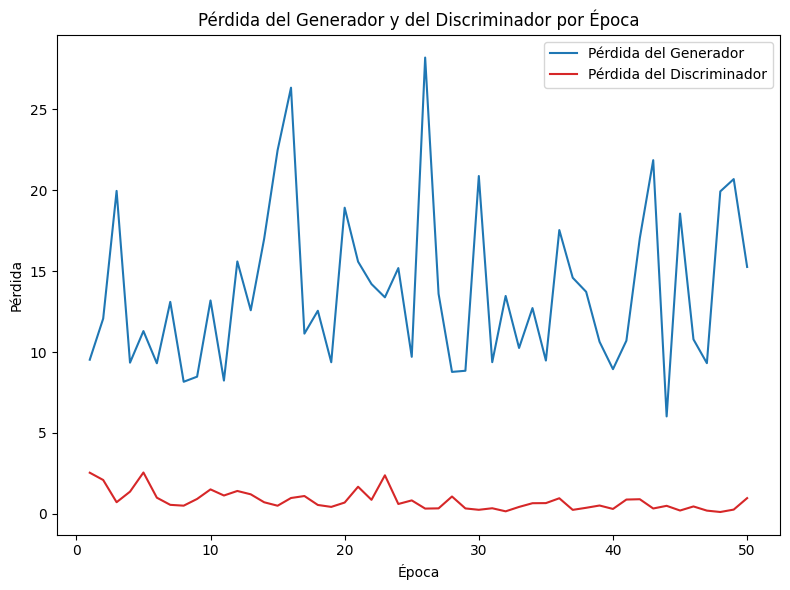

In [21]:
def plot_training_metrics(history):
    # Extraer métricas
    gen_loss = history['gen_total_loss']
    disc_loss = history['disc_loss']

    # Configurar el rango de épocas
    epochs = range(1, len(gen_loss) + 1)

    # Crear gráfico
    plt.figure(figsize=(8, 6))

    plt.plot(epochs, gen_loss, label='Pérdida del Generador', color='tab:blue')
    plt.plot(epochs, disc_loss, label='Pérdida del Discriminador', color='tab:red')

    plt.title('Pérdida del Generador y del Discriminador por Época')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Llamar a la función con los datos de entrenamiento
plot_training_metrics(metric_history)

In [22]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Ruta al archivo de imagen
path_to_image = 'imagenPrueba.jpg'

# Cargar la imagen. Ajusta el tamaño de la imagen (img_height, img_width) según tu modelo
img_height, img_width = 512, 512  # Ejemplo, cambia esto según las necesidades de tu modelo
image = tf.keras.preprocessing.image.load_img(path_to_image, target_size=(img_height, img_width))
image = tf.keras.preprocessing.image.img_to_array(image)

# Normalizar la imagen a [-1, 1]
image = (image / 127.5) - 1

# Añadir una dimensión extra para que la imagen tenga forma (1, altura, anchura, canales)
image = np.expand_dims(image, axis=0)

# Inferencia con el modelo
generated_image = generator_inference.predict(image,training=False)

# Procesar la imagen de salida (si es necesario, dependiendo de cómo tu modelo maneje las salidas)
generated_image = (generated_image * 0.5) + 0.5  # Escalar de [-1,1] a [0,1] si tu modelo devuelve imágenes en ese rango

# Visualizar la imagen
plt.figure(figsize=(8, 8))
plt.imshow(generated_image[0, :, :, :])
plt.axis('off')
plt.show()

TypeError: predict() got an unexpected keyword argument 'training'